In [1]:
import random
import re
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyarrow
import seaborn as sns
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud

import infineac.file_loader as file_loader
import infineac.helper as helper
import infineac.process_event as process_event
import infineac.process_text as process_text
import infineac.topic_extractor as topic_extractor
from infineac.pipeline import pipeline

%load_ext autoreload
%autoreload 2

PATH_DIR = "../data/sample transcripts for notebook/"
KEYWORDS = ["russia", "ukraine"]
BASE_YEAR = 2019
random.seed(111)

/Users/Foal/miniconda3/envs/infineac/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load NLP model

In [2]:
import spacy_stanza
nlp_stanza = spacy_stanza.load_pipeline("en", processors="tokenize, lemma")
nlp_stanza.add_pipe('sentencizer')

2023-11-07 18:37:45 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2023-11-07 18:37:46 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| lemma     | combined |

2023-11-07 18:37:46 WARNING: GPU requested, but is not available!
2023-11-07 18:37:46 INFO: Using device: cpu
2023-11-07 18:37:46 INFO: Loading: tokenize
2023-11-07 18:37:46 INFO: Loading: lemma
2023-11-07 18:37:46 INFO: Done loading processors!


## Load Files

Load all xml files from the given directory and return a list of corresponding events.

In [3]:
files = list(Path(PATH_DIR).rglob("*.xml"))
events = file_loader.load_files_from_xml(files)

Files: 100%|██████████| 500/500 [00:03<00:00, 137.85it/s]


In [4]:
all_comp_df = pl.DataFrame(
    {
        "company_name": [event["company_name"] for event in events],
        "year": [event["date"].year for event in events if "date" in event.keys()],
    }
)
all_comp_df = all_comp_df.with_columns(year=pl.col("year").cast(pl.Int32))

Check if all positions are valid.

In [5]:
process_event.test_positions(events)

## Filter data

Filter out all events that are not in the given time range and do not include the given keywords.

In [6]:
events_filt_all = process_event.filter_events(events, year = BASE_YEAR, keywords = KEYWORDS, modifier_words=[])
events_filt = process_event.filter_events(events, year = BASE_YEAR, keywords = KEYWORDS)
len(events_filt)

Filtering events


Events: 100%|██████████| 500/500 [00:00<00:00, 2138.69it/s]


Filtering events


Events: 100%|██████████| 500/500 [00:02<00:00, 208.06it/s]


84

In [7]:
helper.save_data(events_filt, "data/events_filt.lz4")

List all **events**, that are filtered out due to modifier words preceding the keywords.

In [8]:
events_filtered_filter_words = []
ids_filtered_events = []
for i, event in enumerate(events_filt):
    ids_filtered_events.append(event['id'])
for event in events_filt_all:
    if event['id'] not in ids_filtered_events:
        events_filtered_filter_words.append(event)
print(len(events_filtered_filter_words))
process_event.extract_passages_from_events(events_filtered_filter_words, keywords=KEYWORDS, modifier_words=[], nlp_model=nlp_stanza)

0
Extracting passages from events


Events: 0it [00:00, ?it/s]


[]

List some sentences, that are later filtered out due to modifier words preceding the keywords.

In [9]:
process_event.excluded_sentences_by_mod_words(events_filt[0:100], keywords=KEYWORDS, nlp_model=nlp_stanza)

Documents: 100%|██████████| 84/84 [02:10<00:00,  1.56s/it]


[]

## Exploration

In [10]:
file = [event['file'] for event in events_filt]
id = [event['id'] for event in events_filt]
year_upload = [event['year_upload'] for event in events_filt]
company_name = [event['company_name'] for event in events_filt]
company_ticker = [event['company_ticker'] for event in events_filt]
ticker_new = [re.sub('\\..*', '', t) for t in company_ticker]
dates = [event['date'] for event in events_filt if "date" in event.keys()]
year = [d.year for d in dates]
numeric_values = mdates.date2num(dates)

russia_or_ukr_and_sanction = [process_text.get_russia_and_sanction(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
election = [process_text.get_elections(event['qa_collapsed'] + event['presentation_collapsed']) for event in events_filt]
russia_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('russia') for event in events_filt]
ukraine_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('ukraine') for event in events_filt]
russia_or_ukraine_count = np.array(russia_count) + np.array(ukraine_count)
sanction_count = [str(event['qa_collapsed'] + event['presentation_collapsed']).lower().count('sanction') for event in events_filt]

Create a DataFrame with the following columns:

In [11]:
df_count_keywords = pd.DataFrame({'file': file,
                   'year_upload': year_upload,
                   'company_name': company_name,
                   'ticker':company_ticker,
                   'ticker_new': ticker_new,
                   'date': dates,
                   'year': year,
                   'dates_num' : numeric_values,
                   'russia': russia_or_ukr_and_sanction,
                   'russia_count': russia_count,
                   'ukraine_count': ukraine_count,
                   'russia_or_ukraine_count': russia_or_ukraine_count,
                   'sanction_count': sanction_count,
                   'election': election})

Aggregate the data by **company** and **year**.

In [12]:
df_count_keywords_comp = pl.DataFrame(
    df_count_keywords[
        ["year", "company_name", "russia_count", "ukraine_count", "sanction_count"]
    ]
)
df_count_keywords_comp = df_count_keywords_comp.groupby("company_name", "year").agg(
    pl.col("russia_count", "ukraine_count", "sanction_count").sum()
)
df_count_keywords_comp = df_count_keywords_comp.with_columns(
    year=pl.col("year").cast(pl.Int32)
)
df_count_keywords_comp

company_name,year,russia_count,ukraine_count,sanction_count
str,i32,i64,i64,i64
"""Bank of Montre…",2022,0,1,0
"""Sony Group Cor…",2022,2,1,0
"""Micron Technol…",2022,0,1,0
"""UBS Group AG""",2022,0,1,0
"""CME Group Inc""",2022,3,1,0
"""Dril-Quip Inc""",2022,0,1,0
"""Forage Orbit G…",2022,1,0,0
"""American Inter…",2022,1,1,0
"""Chevron Corp""",2022,2,1,0


Count the number of occasions where the word "russia" (and "sanction") appears in the earnings call.

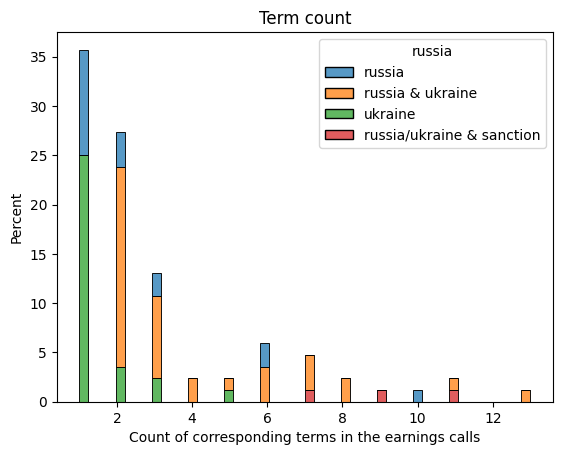

In [13]:
sns.histplot(df_count_keywords[(df_count_keywords['russia_count']>=1) | (df_count_keywords['ukraine_count']>=1)], x='russia_or_ukraine_count', hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Count of corresponding terms in the earnings calls')
plt.ylabel('Percent')
plt.title('Term count')
plt.show()

Average mentions of "russia" per earnings call.

In [14]:
np.array(russia_count).mean()

1.6071428571428572

Average mentions of "russia" per earnings call if "russia" is mentioned at
least once.

In [15]:
np.array([el for el in russia_count if el > 0]).mean()

2.3684210526315788

Average mentions of "sanction" per earnings call.

In [16]:
np.array([el for el in sanction_count if el > 0]).mean()

2.25

Event distribution over time highlighting the different categories.

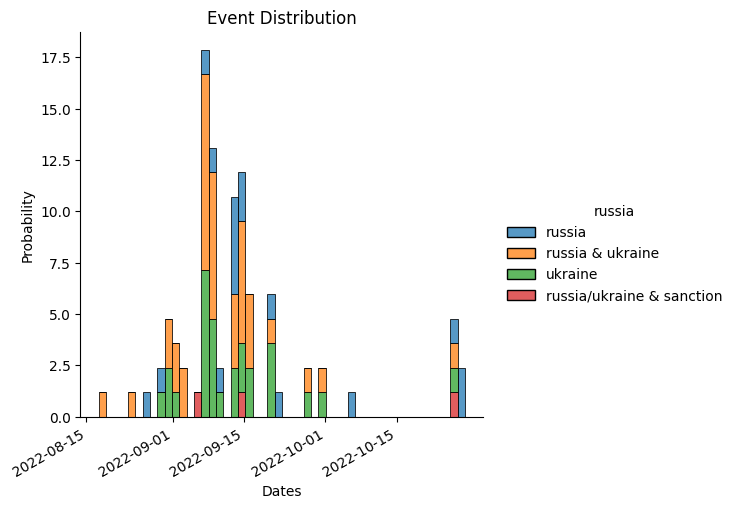

In [17]:
sns.displot(df_count_keywords, x="dates_num", hue="russia", bins=50, stat="percent", common_norm=True, multiple="stack")
plt.xlabel('Dates')
plt.ylabel('Probability')
plt.title('Event Distribution')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

Event proportion over time highlighting the different categories.

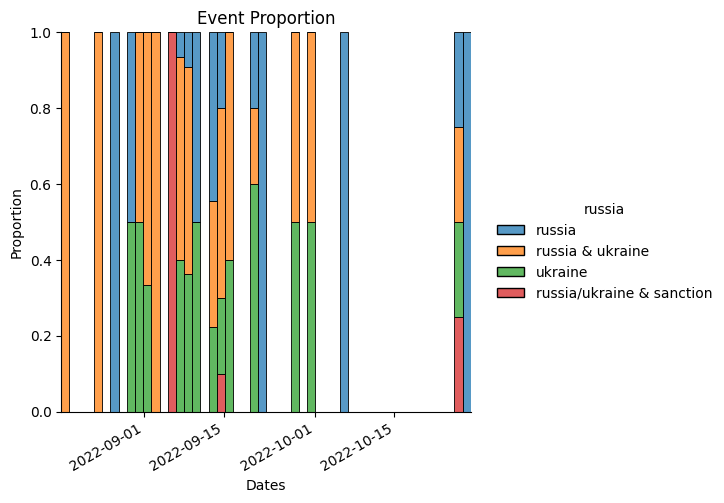

In [18]:
sns.displot(df_count_keywords, x="dates_num", hue="russia", bins=50, stat="proportion", common_norm=True, multiple="fill")
plt.xlabel('Dates')
plt.ylabel('Proportion')
plt.title('Event Proportion')

# Add x-axis ticks and labels
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Customize date format as needed

plt.gcf().autofmt_xdate()  # Adjusts the date labels rotation for better visibility

plt.show()

## Preprocess and extract corpus

In [19]:
# events_filt = helper.load_data("data/events_filt.lz4")

By varying the window size and other parameters, we create different types of
corpora to obtain insights into the significance of these parameters. We will
compare the different results of the corpora to find the set of parameters,
which suits our purpose best.

The different corpora are:

1. Corpus with a window of [0,1] sentence and not joining adjacent sentences.
2. Corpus with a window of [0,1] sentence and joining adjacent sentences.
3. Corpus with a window of [0,3] sentences and joining adjacent sentences.
4. Corpus with a window of [0,5] sentences and joining adjacent sentences.
5. Corpus with a window that includes the whole paragraph from the keywords on.

In [20]:
corpus_window_0_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=False,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
corpus_window_0_df.head()

Extracting passages from events


Events: 100%|██████████| 84/84 [00:06<00:00, 12.68it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 190/190 [00:03<00:00, 51.00it/s]


event_idx,presentation_and_qa_idx,part_idx,paragraph_idx,sentence_idx,text,processed_text,id,years_upload,date,company_name
i64,i64,i64,i64,i64,str,str,i64,i64,datetime[μs],str
0,0,0,0,0,"""In addition, I…","""addition want …",15329330,2022,2022-09-12 21:00:00,"""Oracle Corp"""
1,1,0,0,0,"""And then I thi…","""think turn eur…",15325217,2022,2022-09-15 22:45:00,"""Curtiss-Wright…"
2,0,0,0,0,"""And while COVI…","""impact study s…",15328348,2022,2022-09-08 21:00:00,"""MEI Pharma Inc…"
3,1,0,0,0,"""And I should a…","""add obviously …",15326791,2022,2022-09-07 17:45:00,"""Skechers USA I…"
3,1,0,0,1,"""We're no longe…","""long capable d…",15326791,2022,2022-09-07 17:45:00,"""Skechers USA I…"


In [21]:
corpus_window_0_join_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=0,
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_0_join_df)

Extracting passages from events


Events: 100%|██████████| 84/84 [00:07<00:00, 11.63it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 173/173 [00:03<00:00, 44.79it/s]


173

In [22]:
corpus_window_3_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,2],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_3_df)

Extracting passages from events


Events: 100%|██████████| 84/84 [00:07<00:00, 11.36it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 171/171 [00:04<00:00, 37.45it/s]


171

In [23]:
corpus_window_5_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,4],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_5_df)

Extracting passages from events


Events: 100%|██████████| 84/84 [00:07<00:00, 11.73it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 170/170 [00:04<00:00, 36.56it/s]


170

In [24]:
corpus_window_whole_df = process_event.events_to_corpus(
    events=events_filt,
    keywords=KEYWORDS,
    context_window_sentence=[0,-1],
    subsequent_paragraphs=0,
    join_adjacent_sentences=True,
    extract_answers=False,
    nlp_model=nlp_stanza,
)
len(corpus_window_whole_df)

Extracting passages from events


Events: 100%|██████████| 84/84 [00:07<00:00, 11.57it/s]


Processing corpus with spaCy-pipeline


Documents: 100%|██████████| 171/171 [00:05<00:00, 29.99it/s]


171

Save and load data

In [25]:
helper.save_data(corpus_window_0_df, "data/corpus_window_0_df_no_answer.lz4")
helper.save_data(corpus_window_0_join_df, "data/corpus_window_0_join_df_no_answer.lz4")
helper.save_data(corpus_window_3_df, "data/corpus_window_3_join_df_no_answer.lz4")
helper.save_data(corpus_window_5_df, "data/corpus_window_5_join_df_no_answer.lz4")
helper.save_data(corpus_window_whole_df, "data/corpus_window_whole_join_df_no_answer.lz4")

In [26]:
# corpus_window_0_df = helper.load_data("data/corpus_window_0_df_no_answer.lz4")
# corpus_window_0_join_df = helper.load_data("corpus_window_0_join_df_no_answer.lz4")
# corpus_window_3_df = helper.load_data("data/corpus_window_3_join_df_no_answer.lz4")
# corpus_window_5_df = helper.load_data("data/corpus_window_5_join_df_no_answer.lz4")
# corpus_window_whole_df = helper.load_data("data/corpus_window_whole_join_df_no_answer.lz4")

## Extract Strategies

Add different strategies to the corpus:

In [27]:
corpus_window_0_df = process_text.get_strategies(dataframe=corpus_window_0_df)
corpus_window_0_join_df = process_text.get_strategies(dataframe=corpus_window_0_join_df)
corpus_window_3_df = process_text.get_strategies(dataframe=corpus_window_3_df)
corpus_window_5_df = process_text.get_strategies(dataframe=corpus_window_5_df)
corpus_window_whole_df = process_text.get_strategies(dataframe=corpus_window_whole_df)

Strategies: 100%|██████████| 3/3 [00:00<00:00, 31.10it/s]


Count exit strategies for different corpora

In [28]:
print("Count of exit strategies in smallest corpus:", sum(corpus_window_0_df['exit_strategy']))
print("Count of exit strategies in biggest corpus:", sum(corpus_window_whole_df['exit_strategy']))

Count of exit strategies in smallest corpus: 19
Count of exit strategies in biggest corpus: 22


## Analyse the corpora

### Smallest corpus: [0,1] window and no join

In [29]:
lengths = [len(doc) for doc in corpus_window_0_df['processed_text'].to_list()]
np.max(np.array(lengths))

275

Text(0.5, 9.444444444444438, 'Document length')

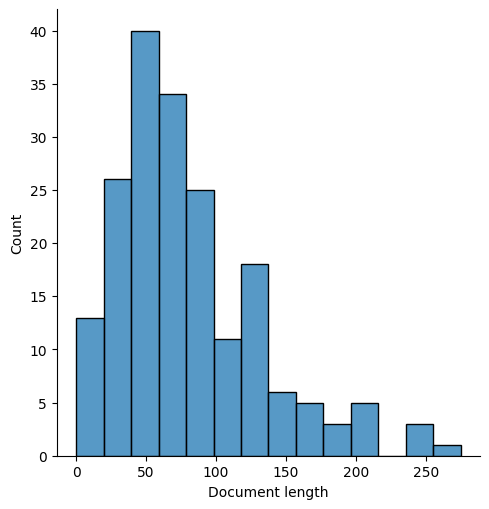

In [30]:
sns.displot(np.array(lengths))
plt.xlabel('Document length')

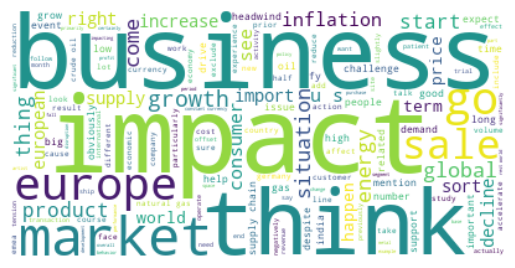

In [31]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_text(" ".join(corpus_window_0_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

### Biggest corpus: whole window and join adjacent sentences

In [32]:
lengths = [len(doc) for doc in corpus_window_whole_df['processed_text'].to_list()]
np.max(np.array(lengths))

2297

Text(0.5, 9.444444444444438, 'Document length')

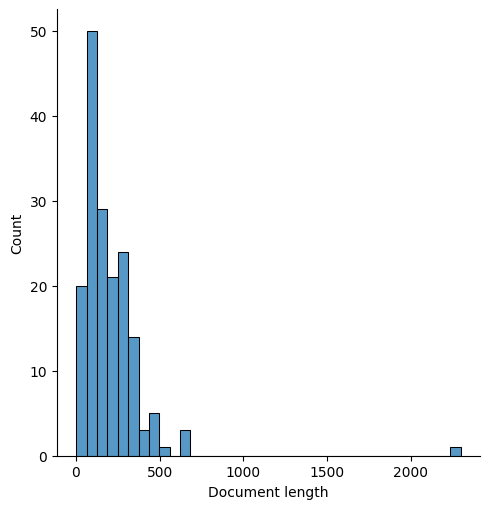

In [33]:
sns.displot(np.array(lengths))
plt.xlabel('Document length')

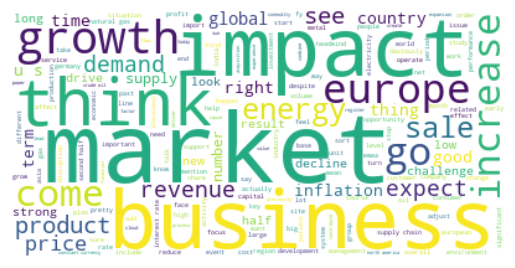

In [34]:
wc = WordCloud(background_color="white", max_words=1000)
wc.generate_from_text(" ".join(corpus_window_whole_df['processed_text'].to_list()))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Extract topics

In [35]:
# main_representation = KeyBERTInspired()
inspired_model = KeyBERTInspired()

# sentence model
sentence_model_light = SentenceTransformer("all-MiniLM-L6-v2")

# mmr model
mmr_model = MaximalMarginalRelevance(diversity=0.4)

# chain models
chain_model_1 = [inspired_model, mmr_model]

# Add all models together to be run in a single `fit`
representation_model = {
   "Main": inspired_model,
   "Chain: Inspired - MMR":  chain_model_1,
}

### 1 - Only sentence
* Sentence window: 0
* No join

In [36]:
results_df_0, results_comp_0, categories_0, categories_count_0 = pipeline(preload_corpus=corpus_window_0_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 6/6 [00:00<00:00, 10.98it/s]
2023-11-07 18:41:10,765 - BERTopic - Transformed documents to Embeddings
2023-11-07 18:41:18,473 - BERTopic - Reduced dimensionality
2023-11-07 18:41:18,502 - BERTopic - Clustered reduced embeddings


In [37]:
categories_count_0

category,Count
str,i64
"""commodity""",39
"""human ressourc…",24
"""macro demand""",20
"""indirect geogr…",11


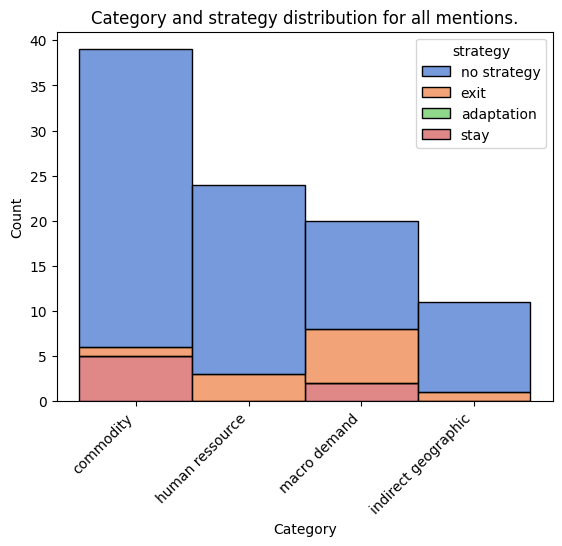

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",90,6,1,8,75
"""commodity""",39,1,0,5,33
"""human ressourc…",24,3,0,0,21
"""macro demand""",20,6,0,2,12
"""indirect geogr…",11,1,0,0,10
"""empty""",6,2,0,0,4


In [38]:
topic_extractor.plot_category_distribution(results_df_0)

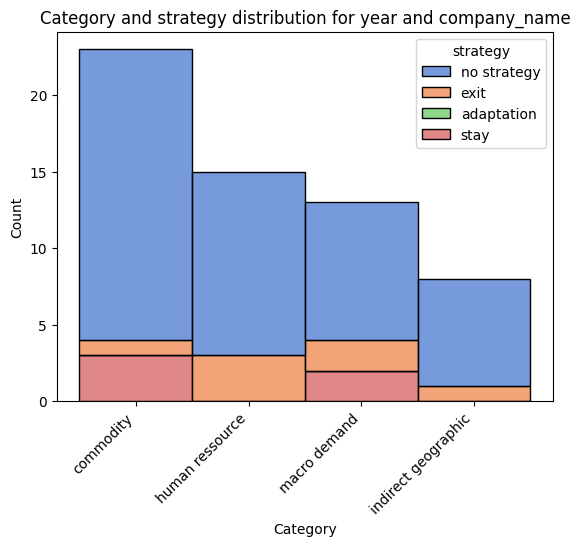

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",51,5,1,7,38
"""commodity""",23,1,0,3,19
"""human ressourc…",15,3,0,0,12
"""macro demand""",13,2,0,2,9
"""indirect geogr…",8,1,0,0,7
"""empty""",5,2,0,0,3


In [39]:
topic_extractor.plot_category_distribution(results_df_0, aggregate=['year', 'company_name'])

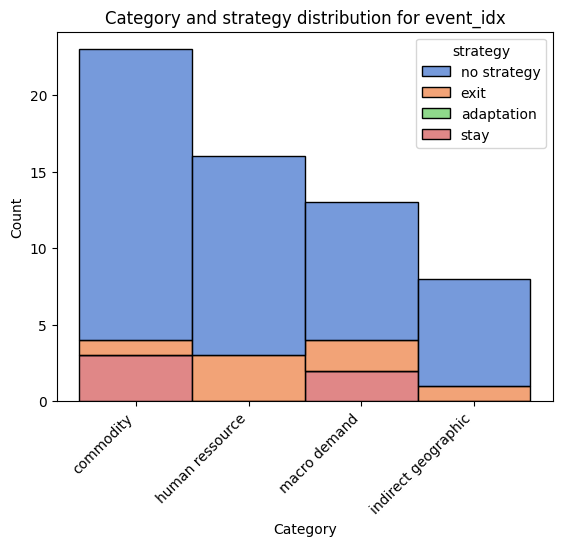

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",52,5,1,7,39
"""commodity""",23,1,0,3,19
"""human ressourc…",16,3,0,0,13
"""macro demand""",13,2,0,2,9
"""indirect geogr…",8,1,0,0,7
"""empty""",5,2,0,0,3


In [40]:
topic_extractor.plot_category_distribution(results_df_0, aggregate=['event_idx'])

In [41]:
results_comp_0 = results_comp_0.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0, on=["company_name", "year"], how="left"
)
helper.save_data(results_df_0, "data/corpus_window_0_df_topic.lz4")
all_comp_results_0.write_excel("data/topics_comp_0.xlsx")

### 2 - Only sentence - join
* Sentence window: 0
* Join sentences

In [42]:
results_df_0_join, results_comp_0_join, categories_0_join, categories_count_0_join = pipeline(preload_corpus=corpus_window_0_join_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 6/6 [00:00<00:00,  7.86it/s]
2023-11-07 18:41:22,773 - BERTopic - Transformed documents to Embeddings
2023-11-07 18:41:24,002 - BERTopic - Reduced dimensionality
2023-11-07 18:41:24,016 - BERTopic - Clustered reduced embeddings


In [43]:
categories_count_0_join

category,Count
str,i64
"""commodity""",34
"""macro demand""",19
"""human ressourc…",12


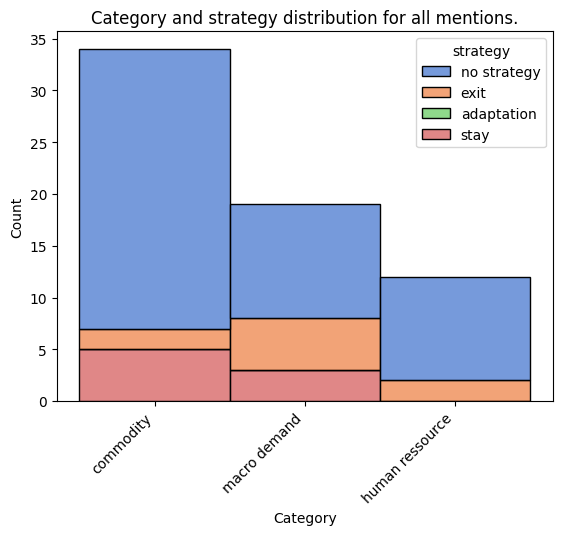

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",104,7,1,7,89
"""commodity""",34,2,0,5,27
"""macro demand""",19,5,0,3,11
"""human ressourc…",12,2,0,0,10
"""empty""",4,1,0,0,3


In [44]:
topic_extractor.plot_category_distribution(results_df_0_join)

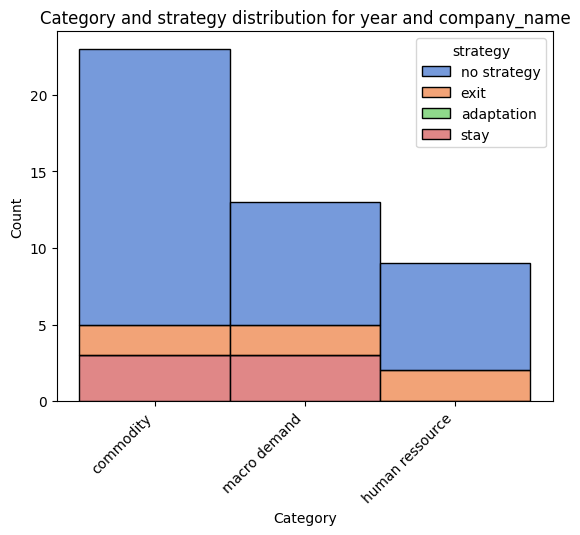

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",58,7,1,7,43
"""commodity""",23,2,0,3,18
"""macro demand""",13,2,0,3,8
"""human ressourc…",9,2,0,0,7
"""empty""",4,1,0,0,3


In [45]:
topic_extractor.plot_category_distribution(results_df_0_join, aggregate=['year', 'company_name'])

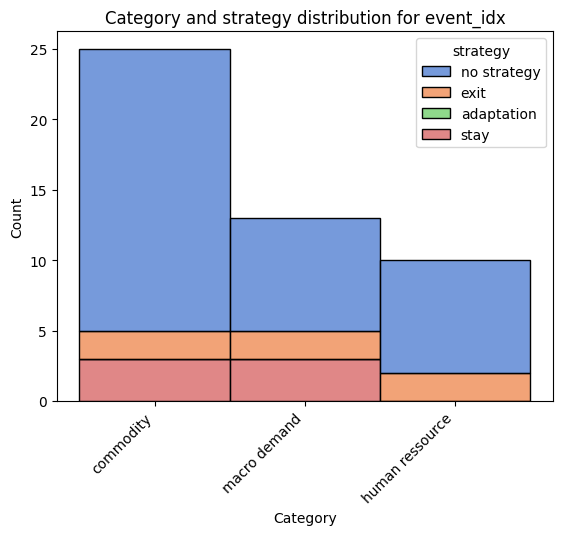

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",59,7,1,7,44
"""commodity""",25,2,0,3,20
"""macro demand""",13,2,0,3,8
"""human ressourc…",10,2,0,0,8
"""empty""",4,1,0,0,3


In [46]:
topic_extractor.plot_category_distribution(results_df_0_join, aggregate=['event_idx'])

In [47]:
results_comp_0_join = results_comp_0_join.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_0 = all_comp_df.join(
    results_comp_0_join, on=["company_name", "year"], how="left"
)
helper.save_data(results_df_0_join, "data/corpus_window_0_join_df_topic.lz4")
all_comp_results_0.write_excel("data/topics_comp_0_join.xlsx")

### 3 - 3 sentences - join
* Sentence window: 3
* Join sentences  

In [48]:
results_df_3, results_comp_3, categories_3, categories_count_3 = pipeline(preload_corpus=corpus_window_3_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 6/6 [00:00<00:00,  7.24it/s]
2023-11-07 18:41:27,665 - BERTopic - Transformed documents to Embeddings
2023-11-07 18:41:28,830 - BERTopic - Reduced dimensionality
2023-11-07 18:41:28,843 - BERTopic - Clustered reduced embeddings


In [49]:
categories_count_3

category,Count
str,i64
"""macro demand""",58
"""commodity""",27


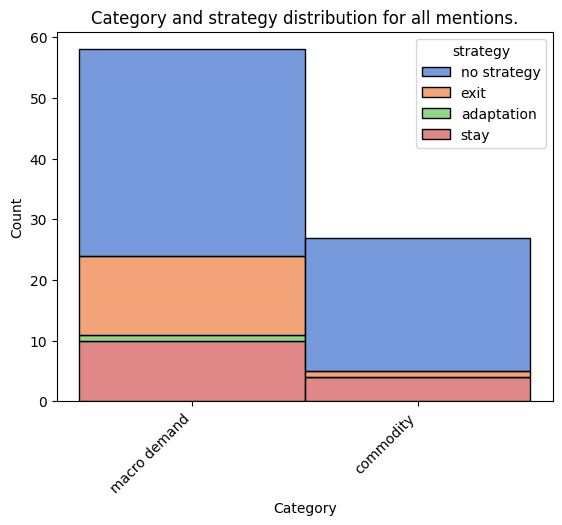

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",84,7,1,12,64
"""macro demand""",58,13,1,10,34
"""commodity""",27,1,0,4,22
"""empty""",2,0,0,0,2


In [50]:
topic_extractor.plot_category_distribution(results_df_3)

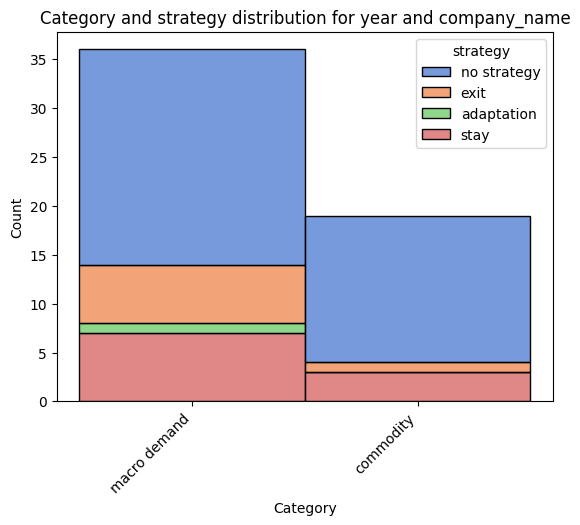

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",53,6,1,12,34
"""macro demand""",36,6,1,7,22
"""commodity""",19,1,0,3,15
"""empty""",2,0,0,0,2


In [51]:
topic_extractor.plot_category_distribution(results_df_3, aggregate=['year', 'company_name'])

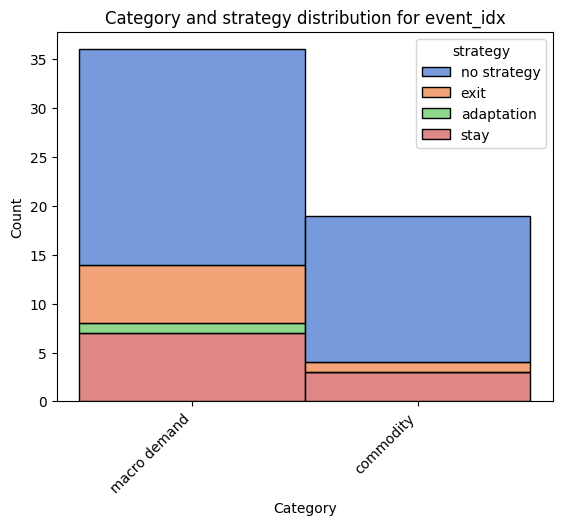

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",55,6,1,12,36
"""macro demand""",36,6,1,7,22
"""commodity""",19,1,0,3,15
"""empty""",2,0,0,0,2


In [52]:
topic_extractor.plot_category_distribution(results_df_3, aggregate=['event_idx'])

In [53]:
results_comp_3 = results_comp_3.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_3 = all_comp_df.join(
    results_comp_3, on=["company_name", "year"], how="left"
)
helper.save_data(results_df_3, "data/corpus_window_3_df_topic.lz4")
all_comp_results_3.write_excel("data/topics_comp_3.xlsx")

### 4. 5 sentences - join
* Sentence window: 5
* Join sentences

In [54]:
results_df_5, results_comp_5, categories_5, categories_count_5 = pipeline(preload_corpus=corpus_window_5_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 6/6 [00:01<00:00,  5.86it/s]
2023-11-07 18:41:32,575 - BERTopic - Transformed documents to Embeddings
2023-11-07 18:41:34,283 - BERTopic - Reduced dimensionality
2023-11-07 18:41:34,294 - BERTopic - Clustered reduced embeddings


In [55]:
categories_count_5

category,Count
str,i64
"""compliance""",29
"""commodity""",18
"""macro demand""",14


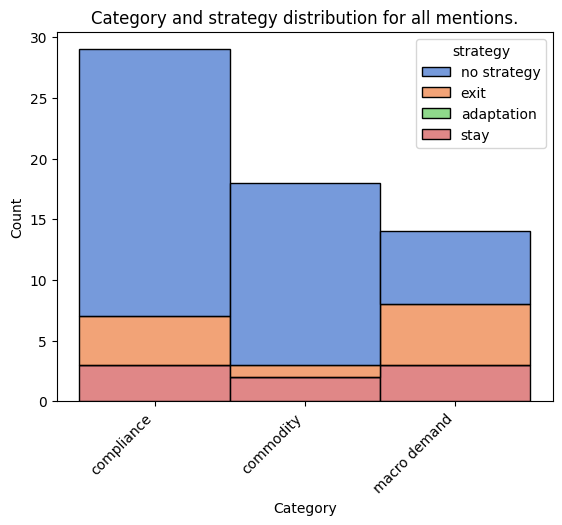

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",107,11,2,20,74
"""compliance""",29,4,0,3,22
"""commodity""",18,1,0,2,15
"""macro demand""",14,5,0,3,6
"""empty""",2,0,0,0,2


In [56]:
topic_extractor.plot_category_distribution(results_df_5)

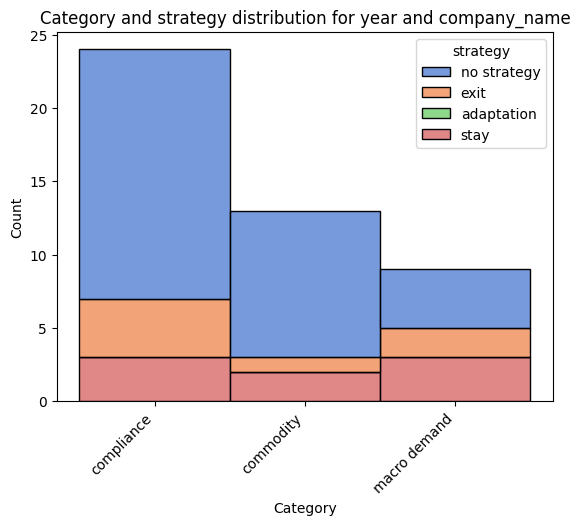

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",65,7,2,17,39
"""compliance""",24,4,0,3,17
"""commodity""",13,1,0,2,10
"""macro demand""",9,2,0,3,4
"""empty""",2,0,0,0,2


In [57]:
topic_extractor.plot_category_distribution(results_df_5, aggregate=['year', 'company_name'])

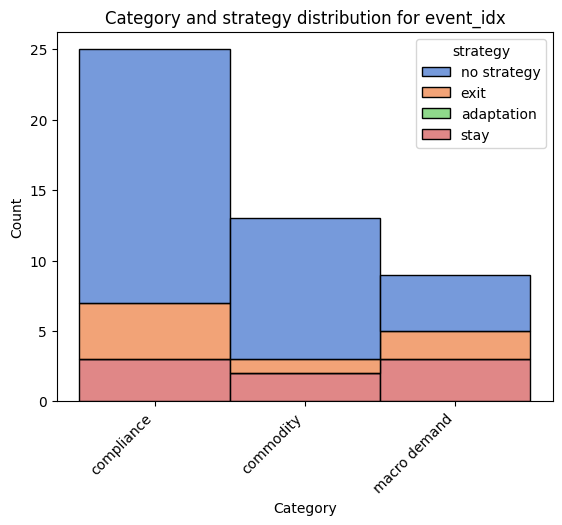

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",67,7,2,17,41
"""compliance""",25,4,0,3,18
"""commodity""",13,1,0,2,10
"""macro demand""",9,2,0,3,4
"""empty""",2,0,0,0,2


In [58]:
topic_extractor.plot_category_distribution(results_df_5, aggregate=['event_idx'])

In [59]:
results_comp_5 = results_comp_5.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_5 = all_comp_df.join(
    results_comp_5, on=["company_name", "year"], how="left"
)
helper.save_data(results_df_5, "data/corpus_window_5_df_topic.lz4")
all_comp_results_5.write_excel("data/topics_comp_5.xlsx")

### 5. Whole paragraph - join
* Sentence window: whole paragraph
* Join sentences

In [60]:
results_df_whole, results_comp_whole, categories_whole, categories_count_whole = pipeline(preload_corpus=corpus_window_whole_df, keywords=KEYWORDS, nlp_model=nlp_stanza, representation_model=representation_model, embedding_model=sentence_model_light)

Batches: 100%|██████████| 6/6 [00:02<00:00,  2.45it/s]
2023-11-07 18:41:39,816 - BERTopic - Transformed documents to Embeddings
2023-11-07 18:41:41,074 - BERTopic - Reduced dimensionality
2023-11-07 18:41:41,086 - BERTopic - Clustered reduced embeddings


In [61]:
categories_count_whole

category,Count
str,i64
"""macro demand""",25
"""finance""",13


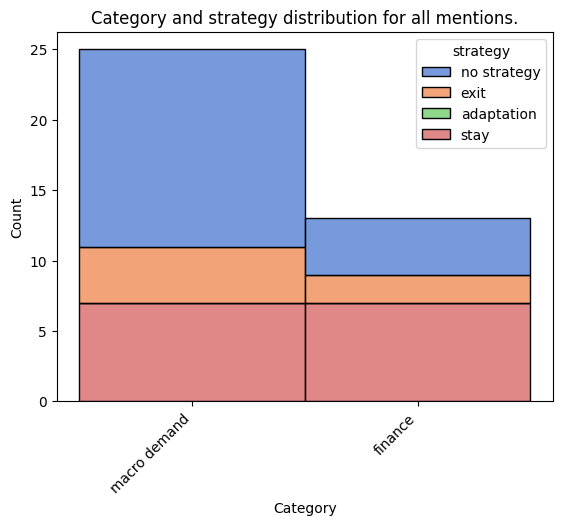

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",131,16,3,23,89
"""macro demand""",25,4,0,7,14
"""finance""",13,2,0,7,4
"""empty""",2,0,0,0,2


In [62]:
topic_extractor.plot_category_distribution(results_df_whole)

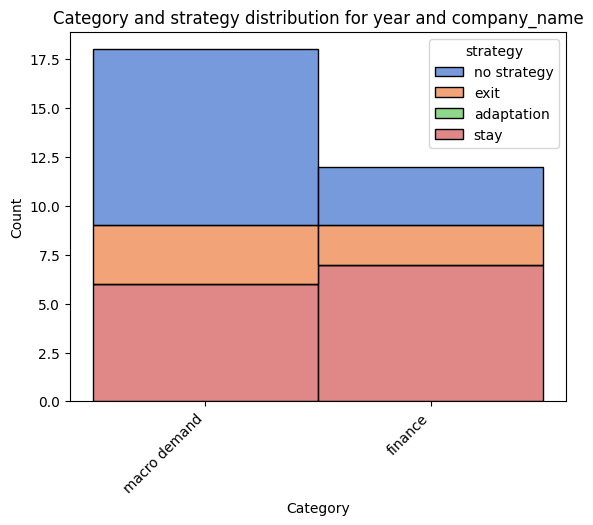

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",67,9,3,18,37
"""macro demand""",18,3,0,6,9
"""finance""",12,2,0,7,3
"""empty""",2,0,0,0,2


In [63]:
topic_extractor.plot_category_distribution(results_df_whole, aggregate=['year', 'company_name'])

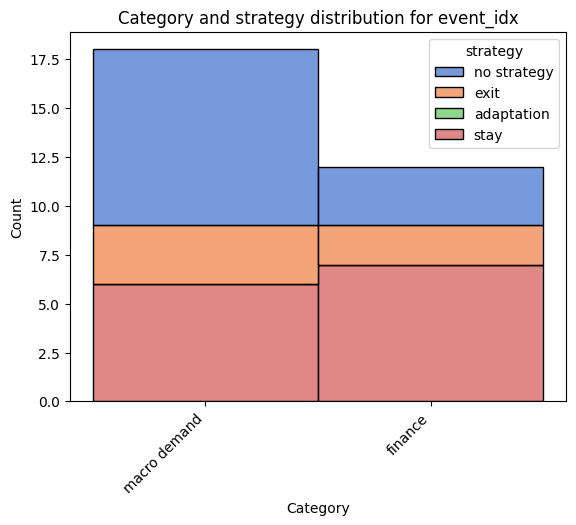

category,count_category,exit,adaptation,stay,no strategy
str,u32,u32,u32,u32,u32
"""standard""",71,9,3,18,41
"""macro demand""",18,3,0,6,9
"""finance""",12,2,0,7,3
"""empty""",2,0,0,0,2


In [64]:
topic_extractor.plot_category_distribution(results_df_whole, aggregate=['event_idx'])

In [65]:
results_comp_whole = results_comp_whole.join(
    df_count_keywords_comp, on=["company_name", "year"], how="left"
)
all_comp_results_whole = all_comp_df.join(
    results_comp_whole, on=["company_name", "year"], how="left"
)
helper.save_data(results_df_whole, "data/corpus_window_whole_df_topic.lz4")
all_comp_results_whole.write_excel("data/topics_comp_whole.xlsx")